In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [309]:
#----- server event ---------
server_event = pd.read_csv('server_event.csv',header=None)
column_names = ['timestamp','machine_id','event_type','event_detail','capacity:CPU','capacity:memory','capacity:disk']
server_event.columns = column_names
#---- batch instance ---------
batch_instance = pd.read_csv('batch_instance.csv', header=None)
column_names = ['start_timestamp','end_timestamp','job_id','task_id','machine_id','status','seq_no','total_seq_no','real_cpu_max','real_cpu_avg','real_mem_max','real_mem_avg']
batch_instance.columns = column_names
#---- batch task --------
batch_task = pd.read_csv('batch_task.csv',header=None)
column_names = ['create_timestamp','modify_timestamp','job_id','task_id','instance_num','status','plan_cpu_per_instance','plan_mem']
batch_task.columns = column_names

In [321]:
batch_instance

,start_timestamp,end_timestamp,job_id,task_id,machine_id,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
0,41562,41618,120.0,686.0,299.0,Terminated,1,1,1.50,0.29,NaN,NaN
1,41561,41619,120.0,686.0,1279.0,Terminated,1,1,0.89,0.28,NaN,NaN
2,41562,41617,120.0,686.0,828.0,Terminated,1,1,0.94,0.29,NaN,NaN
3,41561,41617,120.0,686.0,95.0,Terminated,1,1,1.00,0.31,NaN,NaN
4,41557,41610,120.0,686.0,545.0,Terminated,1,1,1.37,0.29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16094651,73512,73514,NaN,NaN,365.0,Terminated,1,1,1.00,0.93,0.000813,0.000611
16094652,73512,73514,NaN,NaN,13.0,Terminated,1,1,1.00,0.35,0.001098,0.000906
16094653,73512,73518,NaN,NaN,421.0,Terminated,1,1,0.95,0.22,0.001512,0.000890
16094654,73512,73518,NaN,NaN,409.0,Terminated,1,1,0.93,0.25,0.001439,0.000947


In [310]:
total_cpu_capacity = server_event['capacity:CPU'].sum()

print("the cluster cpu capacity：", total_cpu_capacity)

the cluster cpu capacity： 84032


In [311]:
batch_instance_running = batch_instance[batch_instance['status'] == 'Running']

In [316]:
batch_instance_df = batch_instance_running.drop(columns=['seq_no', 'total_seq_no', 'real_cpu_max', 'real_cpu_avg', 'real_mem_max', 'real_mem_avg'], axis=1)

# 筛选出有效的行，即 end_timestamp 大于等于 start_timestamp 的行
batch_instance_df = batch_instance_df[batch_instance_df['end_timestamp'] >= batch_instance_df['start_timestamp']]

In [317]:
batch_task_plan_cpu_per_instance = batch_task[['task_id','plan_cpu_per_instance']]

In [318]:
batch_instance_merged_df = pd.merge(batch_instance_df,batch_task_plan_cpu_per_instance, on='task_id', how='inner')

batch_instance_merged_df = batch_instance_merged_df.sort_values(by='start_timestamp', ascending=True)

In [319]:
batch_instance_merged_df

,start_timestamp,end_timestamp,job_id,task_id,machine_id,status,plan_cpu_per_instance
134230,0,0,1569.0,8708.0,493.0,Running,100.0
53494,0,0,11684.0,71001.0,1130.0,Running,100.0
53495,0,0,11684.0,71001.0,1141.0,Running,100.0
50263,0,0,11666.0,70875.0,1184.0,Running,100.0
8243,0,0,11660.0,70833.0,413.0,Running,100.0
...,...,...,...,...,...,...,...
396723,59196,59197,9347.0,60604.0,404.0,Running,50.0
396724,59196,59197,9347.0,60604.0,716.0,Running,50.0
396725,59196,59197,9347.0,60604.0,159.0,Running,50.0
396727,59196,59197,9347.0,60604.0,586.0,Running,50.0


In [301]:
# 筛选出 "start_timestamp" 和 "end_timestamp" 相同的行
duplicate_timestamps = batch_instance_merged_df[batch_instance_merged_df['start_timestamp'] == batch_instance_merged_df['end_timestamp']]

# 删除选定的行
batch_instance_merged_df.drop(duplicate_timestamps.index, inplace=True)

# 重置索引
batch_instance_merged_df.reset_index(drop=True, inplace=True)

In [302]:
# num and planned CPU resources are collected based on job id
result = batch_instance_merged_df.groupby('job_id').agg({
    'start_timestamp': 'first',                
    'end_timestamp': 'first',               
    'status': 'first',                         
    'plan_cpu_per_instance': 'sum'             
}).reset_index()

## Count the number of rows (num) for each job id
result['instance_num'] = batch_instance_merged_df.groupby('job_id')['status'].size().values

result.rename(columns={
    'start_timestamp': 'start_timestamp',
    'end_timestamp': 'end_timestamp',
    'plan_cpu_per_instance': 'plan_cpu'
}, inplace=True)



In [303]:
result = result.sort_values(by='start_timestamp', ascending=True)
result

,job_id,start_timestamp,end_timestamp,status,plan_cpu,instance_num
661,7030.0,77,167,Running,45100.0,902
662,7033.0,80,162,Running,45900.0,918
1096,12333.0,140,163,Running,57550.0,1151
663,7044.0,278,279,Running,22600.0,452
27,391.0,328,332,Running,91100.0,911
...,...,...,...,...,...,...
466,4972.0,58883,58906,Running,46600.0,932
467,4979.0,58894,59064,Running,15600.0,312
468,4986.0,59056,59074,Running,43200.0,864
469,4990.0,59143,59189,Running,35000.0,700


In [304]:
# 计算 "plan_cpu" 的最大值
max_plan_cpu = result['plan_cpu'].max()

print("plan_cpu的最大值:", max_plan_cpu)

plan_cpu的最大值: 180900.0


/var/folders/kn/7qnp6n29541dg5550wdvzqnr0000gn/T/ipykernel_1893/4205717674.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timestamps_df = pd.DataFrame({


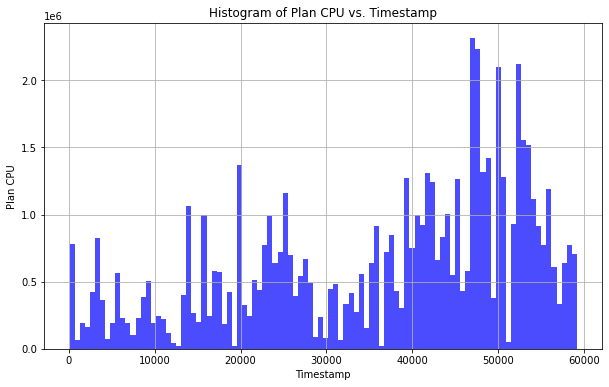

In [305]:
#出以timestamp为x轴，start_timestamp和end_timestamp的区间则为x轴的直方图柱子长度，这样的话每个长度可能都不一样。y轴是plan_cpu
timestamps_df = pd.DataFrame({
    'timestamp': result['start_timestamp'],
    'status': result['status'],
    'plan_cpu': result['plan_cpu']
}).append(pd.DataFrame({
    'timestamp': result['end_timestamp'],
    'status': result['status'],
    'plan_cpu': result['plan_cpu']
}))

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(timestamps_df['timestamp'], bins=100, weights=timestamps_df['plan_cpu'], alpha=0.7, color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Plan CPU')
plt.title('Histogram of Plan CPU vs. Timestamp')
plt.grid(True)
plt.show()

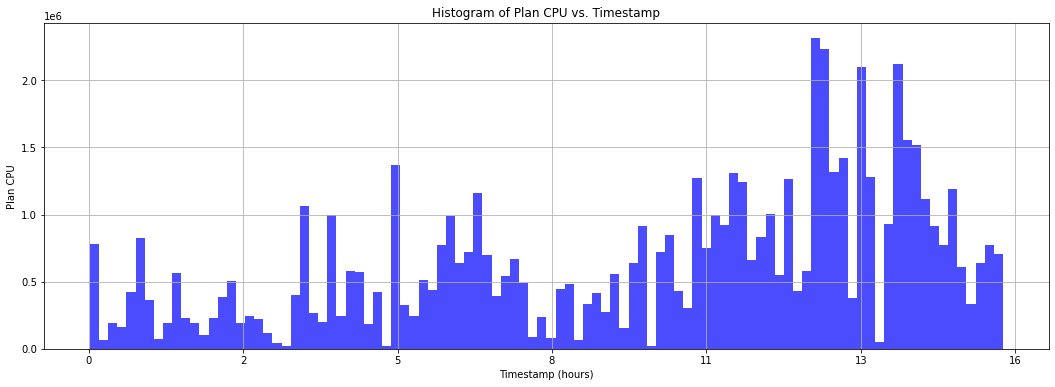

In [306]:
# 根据timestamp对数据进行排序
timestamps_df.sort_values(by='timestamp', inplace=True)

# 绘制直方图
plt.figure(figsize=(18, 6))
plt.hist(timestamps_df['timestamp'], bins=100, weights=timestamps_df['plan_cpu'], alpha=0.7, color='blue')
plt.xlabel('Timestamp (hours)')
plt.ylabel('Plan CPU')
plt.title('Histogram of Plan CPU vs. Timestamp')
plt.grid(True)

# 获取x轴的刻度值，并将刻度值转换为小时并保留整数
x_ticks = plt.xticks()[0]
x_ticks_hours = [int(tick / 3600) for tick in x_ticks]

x_ticks= x_ticks[1:-1]
x_ticks_hours = x_ticks_hours[1:-1]

# 设置x轴刻度值
plt.xticks(x_ticks, x_ticks_hours)

plt.show()


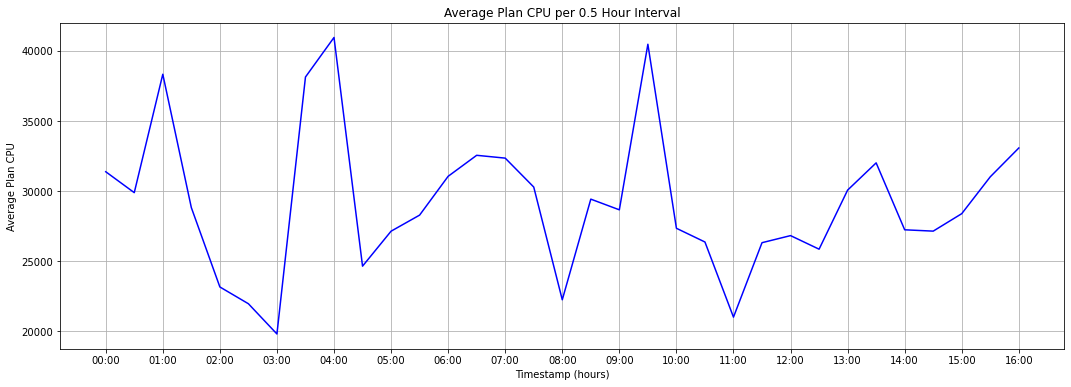

In [307]:
# 将 timestamp 转换为时间索引
timestamps_df.set_index(pd.to_datetime(timestamps_df['timestamp'], unit='s'), inplace=True)

# 按照每 0.5 小时进行重采样，并计算平均值
resampled_df = timestamps_df.resample('30T').mean()

# 输出单位时间内平均 plan_cpu
# print(resampled_df['plan_cpu'])

# 绘制折线图
plt.figure(figsize=(18, 6))
plt.plot(resampled_df.index, resampled_df['plan_cpu'], color='blue')
plt.xlabel('Timestamp (hours)')
plt.ylabel('Average Plan CPU')
plt.title('Average Plan CPU per 0.5 Hour Interval')
plt.grid(True)

# 设置 x 轴刻度格式
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # 每 2 小时显示一个刻度
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 显示小时和分钟

plt.show()


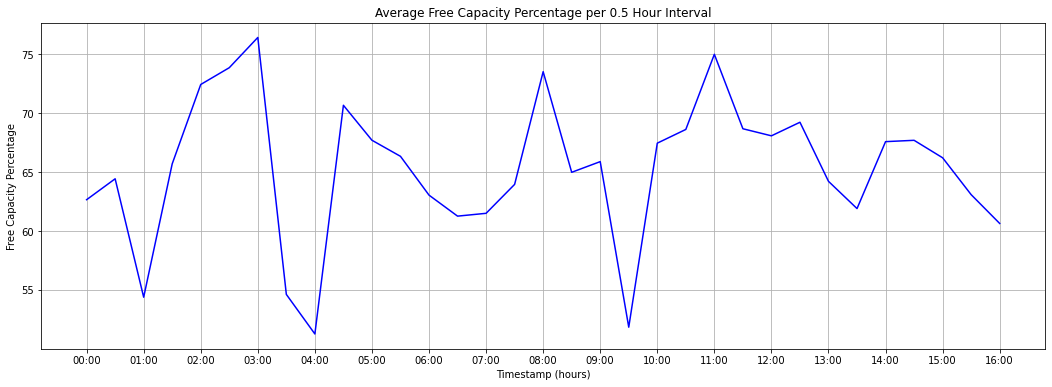

In [308]:
# 将 timestamp 转换为时间索引
timestamps_df.set_index(pd.to_datetime(timestamps_df['timestamp'], unit='s'), inplace=True)

# 按照每 0.5 小时进行重采样，并计算平均值
resampled_df = timestamps_df.resample('30T').mean()

resampled_df['free_capacity_percentage'] = (total_cpu_capacity - resampled_df['plan_cpu']) / total_cpu_capacity * 100

# 输出单位时间内平均 free capacity percentage
# print(resampled_df['free_capacity_percentage'])

# 绘制折线图
plt.figure(figsize=(18, 6))
plt.plot(resampled_df.index, resampled_df['free_capacity_percentage'], color='blue')
plt.xlabel('Timestamp (hours)')
plt.ylabel('Free Capacity Percentage')
plt.title('Average Free Capacity Percentage per 0.5 Hour Interval')
plt.grid(True)

# 设置 x 轴刻度格式
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # 每 2 小时显示一个刻度
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 显示小时和分钟

plt.show()
